# Forecasting Pipelines, Tuning, and AutoML
This notebook is about pipelining and tuning (grid search) for time series forecasting with `sktime`

In [1]:
import warnings

import numpy as np

warnings.filterwarnings("ignore")

## 1. Using exogeneous data `X` in forecasting
The exogenous data `X` is a `pd.DataFrame` with the same index as `y`. It can be given optionally to a forecaster in the `fit` and `predict` methods. If `X` is given in `fit`, it also has to be given in `predict`, this means the future values of `X` have to be available at the time of prediction. 

In [ ]:
from sktime.datasets import load_longley
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

y, X = load_longley()
y_train, y_test, X_train, X_test = temporal_train_test_split(y=y, X=X, test_size=6)
fh = ForecastingHorizon(y_test.index, is_relative=False)

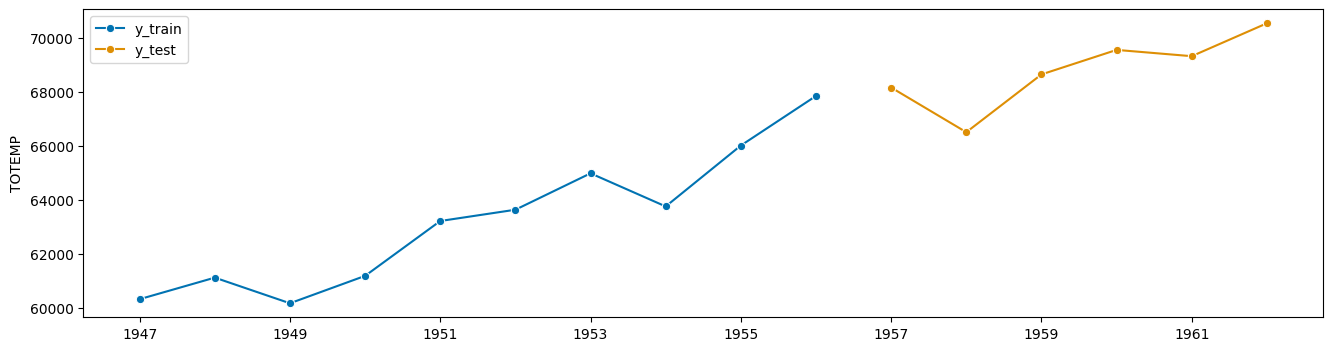

In [3]:
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [4]:
X.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


In [5]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(y=y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)


In case we dont have future `X` values to call `predict(...)`, we can forecast `X` separately by means of the `ForecastX` composition class. This class takes two separate forecasters, one to forecast `y` and another one to forecast `X`. This means that when we call `predict(...)` first the `X` is forecasted and then given to the `y` forecaster to forecast `y`.

In [6]:
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.var import VAR

forecaster_X = ForecastX(
    forecaster_y=AutoARIMA(sp=1, suppress_warnings=True),
    forecaster_X=VAR(),
)
forecaster_X.fit(y=y, X=X, fh=fh)
# now in predict() we don't need to pass X
y_pred = forecaster_X.predict(fh=fh)

## 2. Simple Forecasting Pipelines

We hae seen: pipelines combine multiple estimators into one.

Forecasters methods have two key data arguments, both time series:

* endogeneous data, `y`
* exogeneous data `X`

Pipelines exist for both

### Pipeline transformers on endogenous data - `y` argument 

Sequence of transforms without pipeline object:

In [7]:
from sktime.forecasting.arima import AutoARIMA
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

detrender = Detrender()
deseasonalizer = Deseasonalizer()
forecaster = AutoARIMA(sp=1, suppress_warnings=True)

# fit_transform
y_train_1 = detrender.fit_transform(y_train)
y_train_2 = deseasonalizer.fit_transform(y_train_1)

# fit
forecaster.fit(y_train_2)

# predidct
y_pred_2 = forecaster.predict(fh)

# inverse_transform
y_pred_1 = detrender.inverse_transform(y_pred_2)
y_pred_isolated = deseasonalizer.inverse_transform(y_pred_1)

As one end-to-end forecaster, using `TransformedTargetForecaster` class:

In [8]:
from sktime.forecasting.compose import TransformedTargetForecaster

pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrend", Detrender()),
        ("deseasonalize", Deseasonalizer()),
        ("forecaster", AutoARIMA(sp=1, suppress_warnings=True)),
    ]
)
pipe_y.fit(y=y_train)
y_pred_pipe = pipe_y.predict(fh=fh)

from pandas.testing import assert_series_equal

# make sure that outputs are the same
assert_series_equal(y_pred_pipe, y_pred_isolated)

### Pipeline transformers on exogenous data - `X` argument

Applies transformers to `X` argument before passed to forecaster.

Here: `Detrender` then `Deseasonalizer`, then passed to `AutoARIMA`'s `X`

In [9]:
from sktime.forecasting.compose import ForecastingPipeline

pipe_X = ForecastingPipeline(
    steps=[
        ("detrend", Detrender()),
        ("deseasonalize", Deseasonalizer()),
        ("forecaster", AutoARIMA(sp=1, suppress_warnings=True)),
    ]
)
pipe_X.fit(y=y_train, X=X_train)
y_pred = pipe_X.predict(fh=fh, X=X_test)

### Pipeline on `y` and `X` data by means of nesting

In [10]:
pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrend", Detrender()),
        ("deseasonalize", Deseasonalizer()),
        ("forecaster", AutoARIMA(sp=1, suppress_warnings=True)),
    ]
)

pipe_X = ForecastingPipeline(
    steps=[
        ("detrend", Detrender()),
        ("deseasonalize", Deseasonalizer()),
        ("forecaster", pipe_y),
    ]
)
pipe_X.fit(y=y_train, X=X_train)
y_pred = pipe_X.predict(fh=fh, X=X_test)

`sktime` provides a dunder methods for estimators to chain them into pipelines and other compositions. To create pipelines we can use `*` for creation of a `TransformedTargetForecaster` and `**` for creation of a `ForecastingPipeline`. Further dunder methods are given in the appendinx section at the end of this notebook.

In [11]:
pipe_y = Detrender() * Deseasonalizer() * AutoARIMA()
pipe_y

TransformedTargetForecaster(steps=[Detrender(), Deseasonalizer(), AutoARIMA()])

In [12]:
pipe_X = Detrender() ** Deseasonalizer() ** AutoARIMA()
pipe_X

ForecastingPipeline(steps=[Detrender(), Deseasonalizer(), AutoARIMA()])

nesting with dunders, both `X` and `y`:

In [13]:
pipe_nested = (
    Detrender() * Deseasonalizer() * (Detrender() ** Deseasonalizer() ** AutoARIMA())
)

## 3. Tuning

### Temporal cross-validation

In `sktime` there are three different types of temporal cross-validation splitters available:
- `SingleWindowSplitter`, which is equivalent to a single train-test-split
- `SlidingWindowSplitter`, which is using a rolling window approach and "forgets" the oldest observations as we move more into the future
- `ExpandingWindowSplitter`, which is using a expanding window approach and keep all observations in the training set as we move more into the future

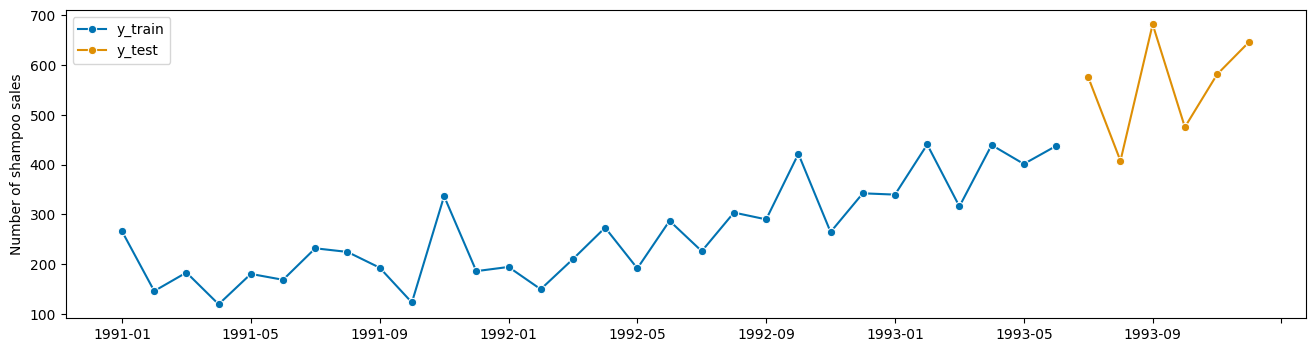

In [14]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [15]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import (
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = ForecastingHorizon(y_test.index, is_relative=False).to_relative(
    cutoff=y_train.index[-1]
)

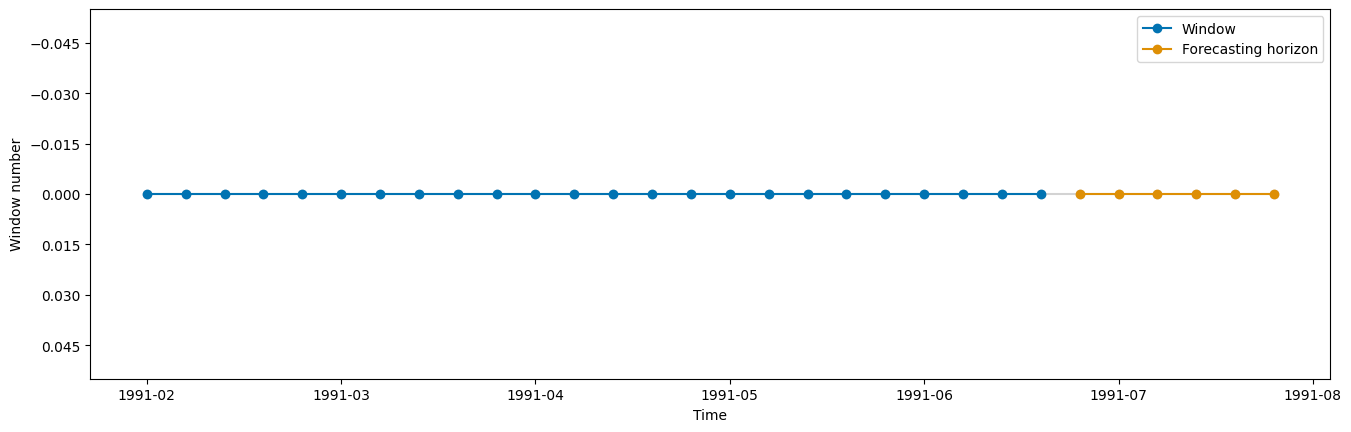

In [16]:
cv = SingleWindowSplitter(fh=fh, window_length=len(y_train) - 6)
plot_windows(cv=cv, y=y_train)

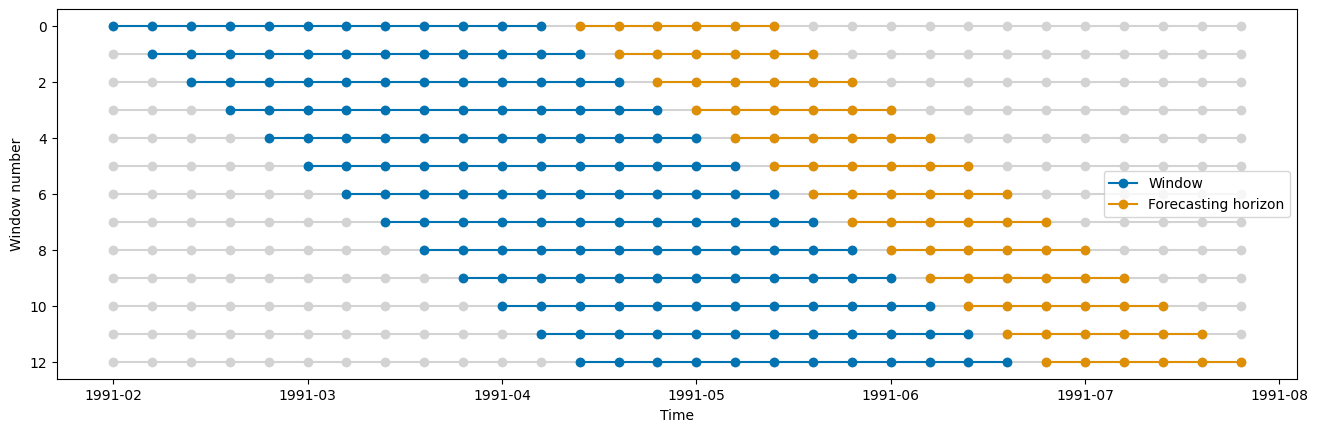

In [17]:
cv = SlidingWindowSplitter(fh=fh, window_length=12, step_length=1)
plot_windows(cv=cv, y=y_train)

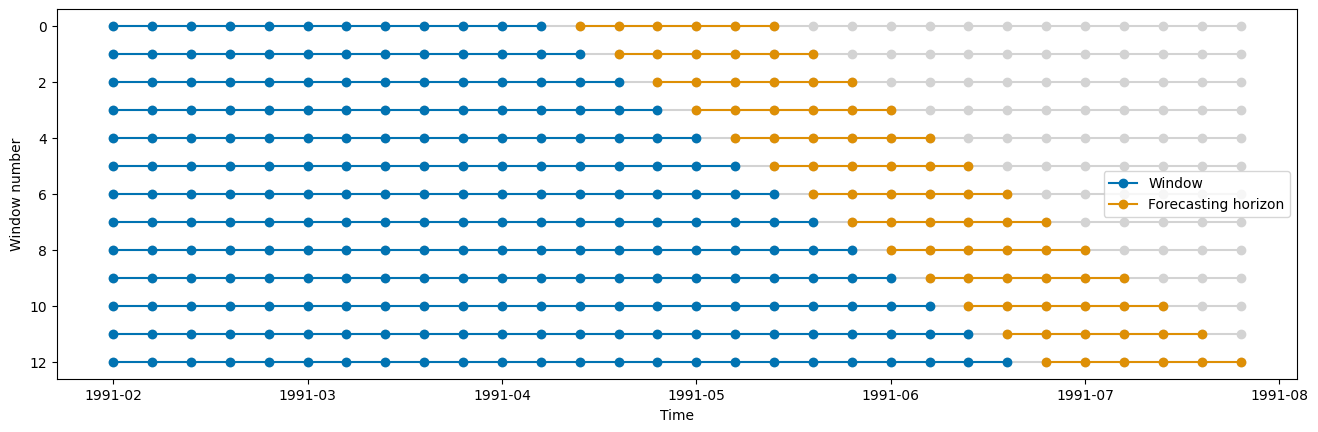

In [18]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=12, step_length=1)
plot_windows(cv=cv, y=y_train)

In [19]:
# get number of total splits (folds)
cv.get_n_splits(y=y_train)

13

### Grid search
Performing a grid search can be done in `sktime` equivalent to `sklearn` by using a cross-validation to search for the best parameter combination. 

In [20]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError

forecaster = ExponentialSmoothing()
param_grid = {
    "sp": [4, 6, 12],
    "seasonal": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 13 folds for each of 24 candidates, totalling 312 fits


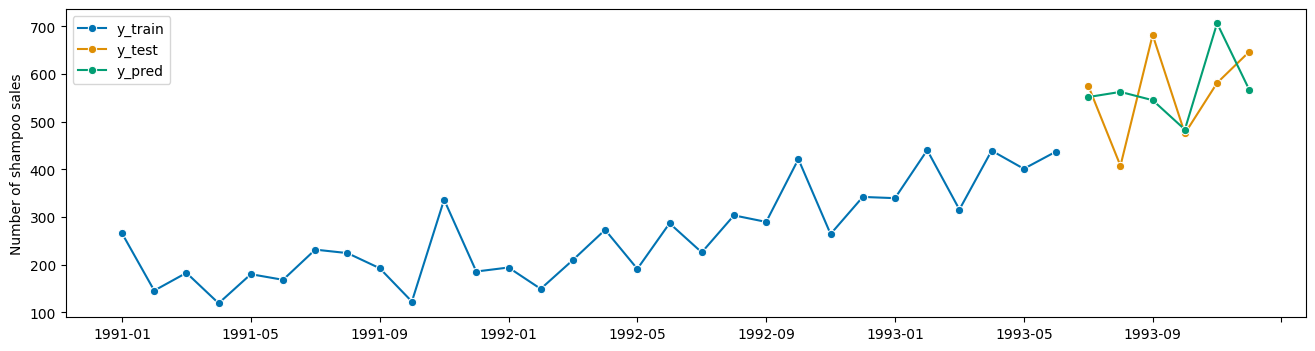

In [21]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [22]:
gscv.best_params_

{'damped_trend': True, 'seasonal': 'add', 'sp': 12, 'trend': 'mul'}

In [23]:
gscv.best_forecaster_

ExponentialSmoothing(damped_trend=True, seasonal='add', sp=12, trend='mul')

In [24]:
gscv.cv_results_.head()

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,98.635359,0.126247,0.004085,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",7.0
1,98.327241,0.137226,0.004455,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",6.0
2,104.567201,0.127894,0.004397,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",13.0
3,112.555601,0.137103,0.004005,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",16.0
4,147.065358,0.107994,0.003920,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",22.0


### Grid search with pipeline

For tuning parameters with compositions such as pipelines, we can use the \<estimator\>__\<parameter\> syntax known from [scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html#composite-estimators-and-parameter-spaces). For multiple levels of nesting, we can use the same syntax with two underscores, e.g. `forecaster__transformer__parameter`.

In [25]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 6, 12],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 13 folds for each of 192 candidates, totalling 2496 fits


In [26]:
gscv.best_params_

{'deseasonalizer__model': 'additive',
 'forecaster__damped_trend': False,
 'forecaster__seasonal': 'add',
 'forecaster__sp': 4,
 'forecaster__trend': 'add',
 'power__transformer__method': 'yeo-johnson',
 'power__transformer__standardize': False}

### Model selection

There are three ways ways to select a model out of multiple models:
1) `ForecastingGridSearchCV`
2) `MultiplexForecaster`
3) `relative_loss` or `RelativeLoss`

#### 1) `ForecastingGridSearchCV`
We can use `ForecastingGridSearchCV` to fit multiple forecasters and find the best one using equivalent notations as in `sklearn`. We can either do: `param_grid: List[Dict]` or we just have a list of forecasters in the grid: `forecaster": [NaiveForecaster(), STLForecaster()]`. The advanteage doing this together tuning the other parameters is that we can use the same cross-validation as for the other parameters to find the overall best forecasters and parameters.

In [27]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import STLForecaster

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("minmax2", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("forecaster", NaiveForecaster()),
    ]
)

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=[
        {
            "scaler__transformer__with_scaling": [True, False],
            "forecaster": [NaiveForecaster()],
            "forecaster__strategy": ["drift", "last", "mean"],
            "forecaster__sp": [4, 6, 12],
        },
        {
            "scaler__transformer__with_scaling": [True, False],
            "forecaster": [STLForecaster(), ThetaForecaster()],
            "forecaster__sp": [4, 6, 12],
        },
    ],
    cv=cv,
)
gscv.fit(y)
gscv.best_params_

{'forecaster': NaiveForecaster(sp=4),
 'forecaster__sp': 4,
 'forecaster__strategy': 'last',
 'scaler__transformer__with_scaling': True}

#### 2) `MultiplexForecaster`
We can use the `MultiplexForecaster` to compare the performance of different forecasters. This approach might be useful if we want to compare the performance of different forecasters that have been tuned and fitted already separately. The `MultiplexForecaster` is just a forecaster compostition that provides a parameters `selected_forecaster: List[str]` that can be tuned with a grid search. The other parameters of the forecasters are not tuned.


In [28]:
from sktime.forecasting.compose import MultiplexForecaster

forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster()),
        ("stl", STLForecaster()),
        ("theta", ThetaForecaster()),
    ]
)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid={"selected_forecaster": ["naive", "stl", "theta"]},
    cv=cv,
)
gscv.fit(y)
gscv.best_params_

{'selected_forecaster': 'theta'}

#### 3) `relative_loss` or `RelativeLoss`
We can compare two models on a given test data by means of a relative loss calculation. This is however not doing any cross-validation compared to the above model selection approaches 1) and 2).

The relative loss function applies a forecasting performance metric to a set of forecasts and benchmark forecasts and reports the ratio of the metric from the forecasts to the the metric from the benchmark forecasts. Relative loss output is non-negative floating point. The best value is 0.0. The relative loss function uses the `mean_absolute_error` by default as error metric. If the score is `>1`, the forecast given as `y_pred` is worse than the given benchmark forecast in `y_pred_benchmark`. If we want to customize the relative loss, we can use the `RelativeLoss` scorer class and e.g. provide a custom loss function.

In [29]:
from sktime.performance_metrics.forecasting import mean_squared_error, relative_loss

relative_loss(y_true=y_test, y_pred=y_pred_1, y_pred_benchmark=y_pred_2)

123.00771294252276

In [30]:
from sktime.performance_metrics.forecasting import RelativeLoss

relative_mse = RelativeLoss(relative_loss_function=mean_squared_error)
relative_mse(y_true=y_test, y_pred=y_pred_1, y_pred_benchmark=y_pred_2)

14720.015012346896

### Tuning pipeline structure as a hyper-parameter

Pipeline structure choices influence performance

`sktime` allows to expose these choices via structural compositors:

* switch between transform/forecast: `MultiplexTransformer`, `MultiplexForecaster`
* transformer on/off: `OptionalPassthrough`
* sequence of transformers: `Permute`

Combine with pipelines and `FeatureUnion` for rich structure space

### Combination of transformers
Given a set of four different transformers, we would like to know which combination of the four transformers is having the best error. So in total there are 4² = 16 different combinations. We can use the `GridSearchCV` to find the best combination.

In [31]:
steps = [
    ("detrender", Detrender()),
    ("deseasonalizer", Deseasonalizer()),
    ("power", TabularToSeriesAdaptor(PowerTransformer())),
    ("scaler", TabularToSeriesAdaptor(RobustScaler())),
    ("forecaster", ExponentialSmoothing()),
]

In `sktime` there is a transformer composition called `OptionalPassthrough()` which gets a transformer as an argument and a param `passthrough: bool`. Setting `passthrough=True` will return an identity transformation for the given data. Setting `passthrough=False` will apply the given inner transformer on the data.

In [32]:
from sktime.transformations.compose import OptionalPassthrough

transformer = OptionalPassthrough(transformer=Detrender(), passthrough=True)
transformer.fit_transform(y_train).head()

1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

In [33]:
y_train.head()

1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

In [34]:
transformer = OptionalPassthrough(transformer=Detrender(), passthrough=False)
transformer.fit_transform(y_train).head()

1991-01    130.376344
1991-02      1.503263
1991-03     29.930182
1991-04    -42.642900
1991-05      9.584019
Freq: M, dtype: float64

In [35]:
forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("power", OptionalPassthrough(TabularToSeriesAdaptor(PowerTransformer()))),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", ExponentialSmoothing()),
    ]
)

param_grid = {
    "detrender__passthrough": [True, False],
    "deseasonalizer__passthrough": [True, False],
    "power__passthrough": [True, False],
    "scaler__passthrough": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)
gscv.fit(y_train)

Fitting 13 folds for each of 16 candidates, totalling 208 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6], dtype='int64', is_relative=True),
                                                   initial_window=12),
                        forecaster=TransformedTargetForecaster(steps=[('detrender',
                                                                       OptionalPassthrough(transformer=Detrender())),
                                                                      ('deseasonalizer',
                                                                       OptionalPassthrough(transformer=Deseasonalizer())),
                                                                      ('power',
                                                                       OptionalPassthrough(transform...
                                                                       OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler()))),
                                                                      ('forecaster',
                                                                       ExponentialSmoothing())]),
                        n_jobs=-1,
                        param_grid={'deseasonalizer__passthrough': [True,
                                                                    False],
                                    'detrender__passthrough': [True, False],
                                    'power__passthrough': [True, False],
                                    'scaler__passthrough': [True, False]},
                        scoring=MeanSquaredError(square_root=True), verbose=1)

Best performing combination of transformers:

In [36]:
gscv.best_params_

{'deseasonalizer__passthrough': True,
 'detrender__passthrough': False,
 'power__passthrough': True,
 'scaler__passthrough': True}

Worst performing combination of transformers:

In [37]:
# worst params
gscv.cv_results_.sort_values(by="mean_test_MeanSquaredError", ascending=True).iloc[-1][
    "params"
]

{'deseasonalizer__passthrough': False,
 'detrender__passthrough': True,
 'power__passthrough': False,
 'scaler__passthrough': True}

### Permutation of transformers

Given a set of four different transformers, we would like to know which permutation (ordering) of the four transformers is having the best error. In total there are `4! = 24` different permutations. We can use the `GridSearchCV` to find the best permutation.

In [38]:
from sktime.forecasting.compose import Permute

In [39]:
forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

param_grid = {
    "permutation": [
        ["detrender", "deseasonalizer", "power", "scaler", "forecaster"],
        ["power", "scaler", "detrender", "deseasonalizer", "forecaster"],
        ["scaler", "deseasonalizer", "power", "detrender", "forecaster"],
        ["deseasonalizer", "power", "scaler", "detrender", "forecaster"],
    ]
}
permuted = Permute(estimator=forecaster, permutation=None)

gscv = ForecastingGridSearchCV(
    forecaster=permuted,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)

permuted = gscv.fit(y, fh=fh)

Fitting 19 folds for each of 4 candidates, totalling 76 fits


In [40]:
permuted.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,104.529303,0.119823,0.032105,"{'permutation': ['detrender', 'deseasonalizer'...",4.0
1,95.172818,0.118840,0.033758,"{'permutation': ['power', 'scaler', 'detrender...",1.5
2,95.243942,0.114363,0.033743,"{'permutation': ['scaler', 'deseasonalizer', '...",3.0
3,95.172818,0.119377,0.030739,"{'permutation': ['deseasonalizer', 'power', 's...",1.5


In [41]:
gscv.best_params_

{'permutation': ['power',
  'scaler',
  'detrender',
  'deseasonalizer',
  'forecaster']}

In [42]:
# worst params
gscv.cv_results_.sort_values(by="mean_test_MeanSquaredError", ascending=True).iloc[-1][
    "params"
]

{'permutation': ['detrender',
  'deseasonalizer',
  'power',
  'scaler',
  'forecaster']}

## 4. Putting it all together: AutoML-like pipeline and tuning

Taking all incredients from above examples, we can build a forecaster that comes close to what is usually called [AutoML](https://en.wikipedia.org/wiki/Automated_machine_learning).
With AutoML we aim to automate as many steps of an ML model creation as possible. The main compositions from `sktime` that we can use for this are:
- `TransformedTargetForecaster`
- `ForecastingPipeline`
- `ForecastingGridSearchCV`
- `OptionalPassthrough`
- `Permute`

### Univariate example
Please see appendix section for an example with exogenous data

In [43]:
pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", STLForecaster()),
    ]
)
permuted_y = Permute(estimator=pipe_y, permutation=None)

param_grid = {
    "permutation": [
        ["detrender", "deseasonalizer", "scaler", "forecaster"],
        ["scaler", "deseasonalizer", "detrender", "forecaster"],
    ],
    "estimator__detrender__passthrough": [True, False],
    "estimator__deseasonalizer__passthrough": [True, False],
    "estimator__scaler__passthrough": [True, False],
    "estimator__scaler__transformer__transformer__with_scaling": [True, False],
    "estimator__scaler__transformer__transformer__with_centering": [True, False],
    "estimator__forecaster__sp": [4, 8, 12],
}

gscv = ForecastingGridSearchCV(
    forecaster=permuted_y,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
    error_score="raise",
)

gscv.fit(y=y_train, fh=fh)

Fitting 13 folds for each of 192 candidates, totalling 2496 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6], dtype='int64', is_relative=True),
                                                   initial_window=12),
                        error_score='raise',
                        forecaster=Permute(estimator=TransformedTargetForecaster(steps=[('detrender',
                                                                                         OptionalPassthrough(transformer=Detrender())),
                                                                                        ('deseasonalizer',
                                                                                         OptionalPassthrough(transformer=Deseasonalizer())),...
                                    'estimator__scaler__passthrough': [True,
                                                                       False],
                                    'estimator__scaler__transformer__transformer__with_centering': [True,
                                                                                                    False],
                                    'estimator__scaler__transformer__transformer__with_scaling': [True,
                                                                                                  False],
                                    'permutation': [['detrender',
                                                     'deseasonalizer', 'scaler',
                                                     'forecaster'],
                                                    ['scaler', 'deseasonalizer',
                                                     'detrender',
                                                     'forecaster']]},
                        scoring=MeanSquaredError(square_root=True), verbose=1)

In [44]:
gscv.cv_results_["mean_test_MeanSquaredError"].min()

83.44136911735615

In [45]:
gscv.cv_results_["mean_test_MeanSquaredError"].max()

125.54124792614672

## 5. Model backtesting

After fitting a model, we can evaluate the model error in the past similar to a cross-validation. For this we can use the `evaluate` function. This approach is often also called backtesting as we want to test the forecasters performance in the past.

In [46]:
from sktime.forecasting.model_evaluation import evaluate

y = load_shampoo_sales()
results = evaluate(
    forecaster=STLForecaster(sp=12),
    y=y,
    cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6], initial_window=12, step_length=6),
    scoring=MeanSquaredError(square_root=True),
    return_data=True,
)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,85.405220,0.008634,0.009597,12,1991-12,Period 1991-01 266.0 1991-02 145.9 1991-...,Period 1992-01 194.3 1992-02 149.5 1992-...,1992-01 266.0 1992-02 145.9 1992-03 1...
1,129.383456,0.010045,0.007728,18,1992-06,Period 1991-01 266.0 1991-02 145.9 1991-...,Period 1992-07 226.0 1992-08 303.6 1992-...,1992-07 270.953646 1992-08 263.653646 19...
2,126.393156,0.009373,0.008245,24,1992-12,Period 1991-01 266.0 1991-02 145.9 1991-...,Period 1993-01 339.7 1993-02 440.4 1993-...,1993-01 260.633333 1993-02 215.833333 19...
3,171.142305,0.012287,0.009526,30,1993-06,Period 1991-01 266.0 1991-02 145.9 1991-...,Period 1993-07 575.5 1993-08 407.6 1993-...,1993-07 378.659609 1993-08 450.927848 19...


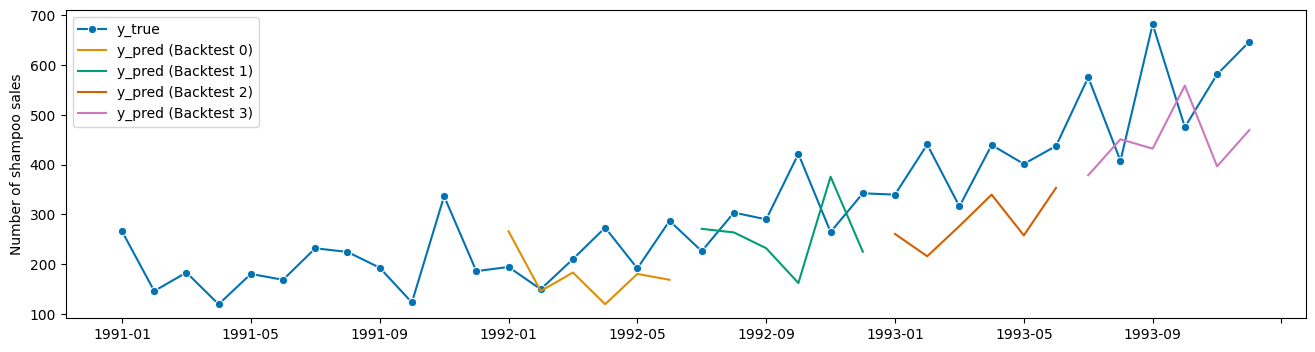

In [47]:
plot_series(
    y,
    results["y_pred"].iloc[0],
    results["y_pred"].iloc[1],
    results["y_pred"].iloc[2],
    results["y_pred"].iloc[3],
    markers=["o", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(4)],
);

## 4.6 Appendix

### AutoML-like pipeline with exog data

In [48]:
from sktime.datasets import load_macroeconomic

data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=40)

fh = ForecastingHorizon(np.arange(1, 41), is_relative=True)

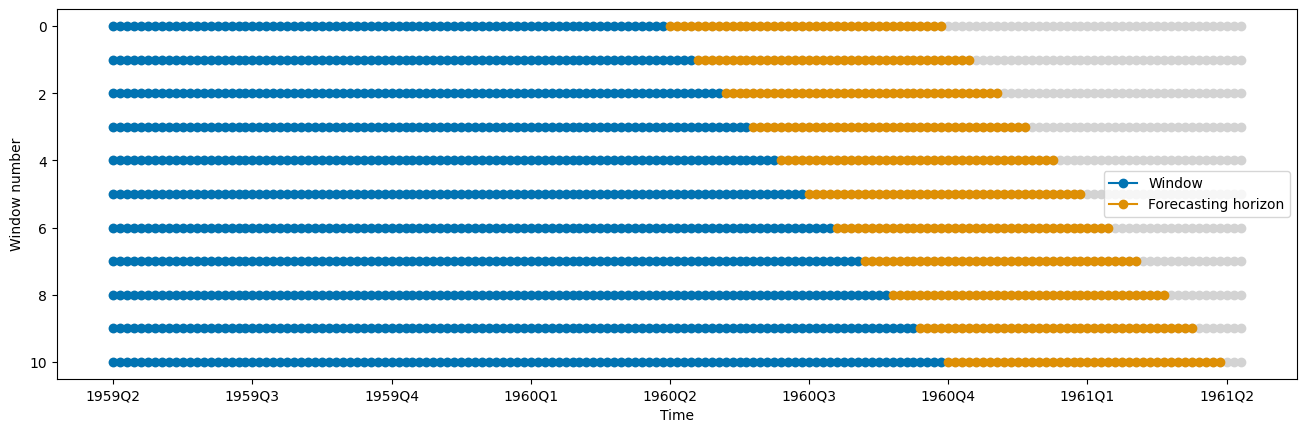

In [49]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=80, step_length=4)
plot_windows(cv=cv, y=y_train)

In [50]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.split import temporal_train_test_split

data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=40)
fh = ForecastingHorizon(np.arange(1, 41), is_relative=True)

pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", StatsForecastAutoARIMA(sp=4)),
    ]
)
permuted_y = Permute(pipe_y, permutation=None)

pipe_X = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", permuted_y),
    ]
)
permuted_X = Permute(pipe_X, permutation=None)

In [51]:
gscv = ForecastingGridSearchCV(
    forecaster=permuted_X,
    param_grid={
        "estimator__forecaster__permutation": [
            ["detrender", "deseasonalizer", "scaler", "forecaster"],
            ["scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "permutation": [
            ["detrender", "deseasonalizer", "scaler", "forecaster"],
            ["scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "estimator__forecaster__estimator__scaler__passthrough": [True, False],
        "estimator__scaler__passthrough": [True, False],
    },
    cv=cv,
    error_score="raise",
    scoring=MeanSquaredError(square_root=True),
)

gscv.fit(y=y_train, X=X_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40],
           dtype='int64', is_relative=True),
                                                   initial_window=80,
                                                   step_length=4),
                        error_score='raise',
                        forecaster=Permute(estimator=TransformedTargetForecaster(steps=[('detrender',
                                                                                         Op...
                                    'estimator__forecaster__permutation': [['detrender',
                                                                            'deseasonalizer',
                                                                            'scaler',
                                                                            'forecaster'],
                                                                           ['scaler',
                                                                            'detrender',
                                                                            'deseasonalizer',
                                                                            'forecaster']],
                                    'estimator__scaler__passthrough': [True,
                                                                       False],
                                    'permutation': [['detrender',
                                                     'deseasonalizer', 'scaler',
                                                     'forecaster'],
                                                    ['scaler', 'detrender',
                                                     'deseasonalizer',
                                                     'forecaster']]},
                        scoring=MeanSquaredError(square_root=True))

In [52]:
gscv.cv_results_["mean_test_MeanSquaredError"].min()

1.9856591203311482

In [53]:
gscv.cv_results_["mean_test_MeanSquaredError"].max()

2.1207628182179863

In [54]:
gscv.best_params_

{'estimator__forecaster__estimator__scaler__passthrough': True,
 'estimator__forecaster__permutation': ['detrender',
  'deseasonalizer',
  'scaler',
  'forecaster'],
 'estimator__scaler__passthrough': False,
 'permutation': ['detrender', 'deseasonalizer', 'scaler', 'forecaster']}

In [55]:
# worst params
gscv.cv_results_.sort_values(by="mean_test_MeanSquaredError", ascending=True).iloc[-1][
    "params"
]

{'estimator__forecaster__estimator__scaler__passthrough': True,
 'estimator__forecaster__permutation': ['scaler',
  'detrender',
  'deseasonalizer',
  'forecaster'],
 'estimator__scaler__passthrough': True,
 'permutation': ['scaler', 'detrender', 'deseasonalizer', 'forecaster']}

---

### Credits: notebook - pipelines

notebook creation: aiwalter

forecaster pipelines: fkiraly, aiwalter\
transformer pipelines & compositors: fkiraly, mloning, miraep8\
dunder interface: fkiraly, miraep8\

tuning, autoML: mloning, fkiraly, aiwalter\
CV and splitters: mloning, kkoralturk, khrapovs\
forecasting metrics: mloning, aiwalter, rnkuhns, fkiraly\
backtesting, evaluation: aiwalter, mloning, fkiraly, topher-lo